In [21]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt 
from PIL import Image
import glob

data_dir = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/'

In [26]:
class PickGoodCandidates:
    def __init__(self, img_dir, depth_dir):
        self.imgdir = img_dir
        self.depthdir = depth_dir
        self.filtered = False
        
    def is_open_contour(self, c):
        # check for a bunch of edge points
        # c is of the format num_points * 1 * 2
        edge_points = []
        for x in c:
            if x[0][0] == 0 or x[0][1] == 0 or x[0][0] == 511 or x[0][1] == 511:
                edge_points.append(x)
#         print(len(edge_points))
        if len(edge_points) > 0:
            return True
        return False

    def find_nearest(self, x):
        dist = 10000
        res = -1
        for y, _ in self.good_candidates:
            if abs(x-y) < dist:
                dist = abs(x-y)
                res = y
        return res
    
    def sample_uniform_nn(self, n):
        if not self.filtered:
            self.filter_candidates()
            
        num_imgs = len(glob.glob(self.imgdir + '/*.jpg'))
        print(f'num_imgs {num_imgs}')
        delta = int(num_imgs / n)
        cand = [delta*x for x in range(1,n+1)]
        return [self.find_nearest(x) for x in cand]
        # first select n uniformly sampled images, then for each find the nearest good candidate
#         pass
        
    def sample_n(self, n):
        if not self.filtered:
            self.filter_candidates()
            
        # uniformly sample 
        # randomly sample 
        return [x[0] for x in random.sample(self.good_candidates, n)]
    
    def filter_candidates(self):
        self.good_candidates = []
        self.bad_candidates = []
        for x in range(len(os.listdir(img_dir)) + 1):
            res, contours = self.is_good_candidate(x)
            if res == True:
                self.good_candidates.append((x, contours))
            elif res == False:
                self.bad_candidates.append(x)
                
        print(f'{len(self.good_candidates)} found, {len(self.bad_candidates)} bad candidates')
        self.filtered = True
#         print(f'good candidates {self.good_candidates}')
            
    def visualize_good_bad(self, num):
        # TODO: sample num numbers from all, then look at he 
        # sample num from good bad
        good = random.sample(self.good_candidates, num)
        bad = random.sample(self.bad_candidates, num)
        
        for x in range(num):
            gim = os.path.join(self.imgdir, "{:05d}.jpg".format(good[x][0]))
            gim = cv2.cvtColor(cv2.imread(gim), cv2.COLOR_BGR2RGB)
            
            bim = os.path.join(self.imgdir, "{:05d}.jpg".format(bad[x]))
            bim = cv2.cvtColor(cv2.imread(bim), cv2.COLOR_BGR2RGB)
            
            arr = [gim, bim]
            titles = ['good', 'bad']
            plt.figure(figsize=(5,4))
            for i, data in enumerate(arr):
                ax = plt.subplot(1, 2, i+1)
                ax.axis('off')
                ax.set_title(titles[i])
                plt.imshow(data)
            plt.show()
        
    def is_good_candidate(self, x):
        dpath = os.path.join(self.depthdir, "{:05d}.npy".format(x))
        imgpath = os.path.join(self.imgdir, "{:05d}.jpg".format(x))
        if not os.path.isfile(imgpath):
            return None, None
#         print(imgpath)
        img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)

        d = np.load(dpath)

        d = cv2.normalize(d, None, alpha = 0, beta = 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        d *= 255
        avgd = np.mean(d)
        ret,th = cv2.threshold(d,avgd/2,255, cv2.THRESH_BINARY)
#         print(type(th), th.shape, th.dtype, img.dtype)
        
        contours, hierarchy = cv2.findContours(th.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
#         print(len(contours), type(hierarchy))
        
        valid_contours = []
        
        for i in contours:
            if not self.is_open_contour(np.asarray(i)) and cv2.contourArea(i) > 100:
                valid_contours.append(i)
#             print(cv2.isContourConvex(i), cv2.contourArea(i), cv2.arcLength(i,True))
#             print(len(i), np.asarray(i).shape)
#             print(f'is_open_contour {self.is_open_contour(np.asarray(i))}')

        return len(valid_contours) > 0, valid_contours
        
    def vis(self, x, contours=None):
        
        imgpath = os.path.join(self.imgdir, "{:05d}.jpg".format(x))
        image = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
        
        if contours:
            image = cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
        
#         print(f'{len(valid_contours)} valid contours')

    #     print(d)
    #     depth_img = Image.fromarray((d / 10 * 255).astype(np.uint8), mode="L")

#         img = cv2.imread(imgpath)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        arr = [image]
        titles = ['rgb']
        plt.figure(figsize=(5,4))
        for i, data in enumerate(arr):
    #         print(f'data.shape {data.shape}')
            ax = plt.subplot(1, 1, i+1)
            ax.axis('off')
            ax.set_title(titles[i])
            plt.imshow(data)
        plt.show()

trajectory 1
312 found, 1205 bad candidates
num_imgs 1517
[304, 566, 916, 1203, 1493]


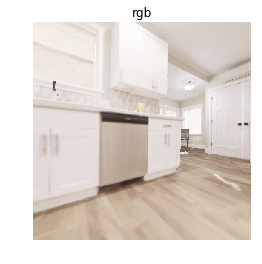

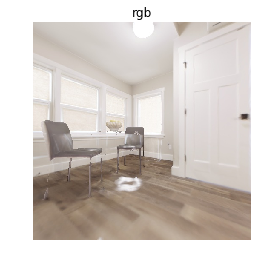

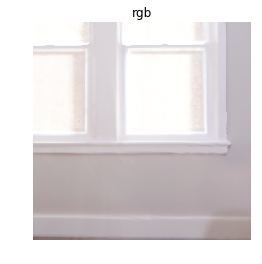

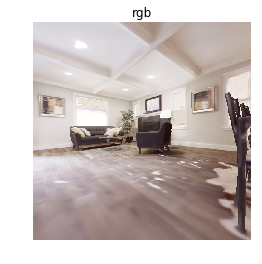

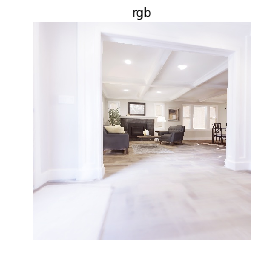

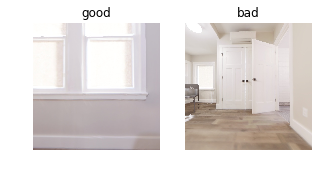

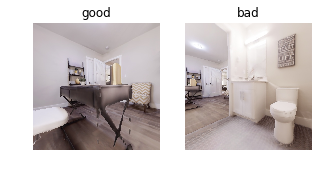

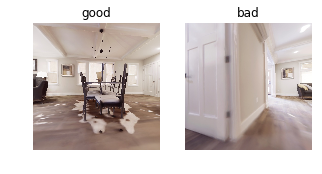

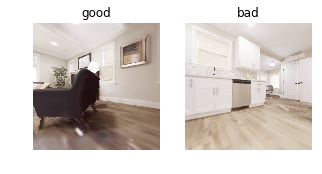

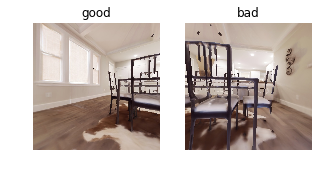

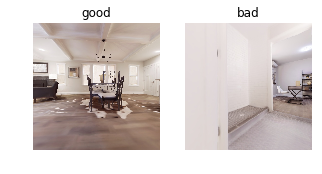

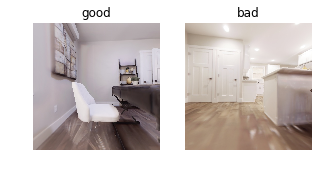

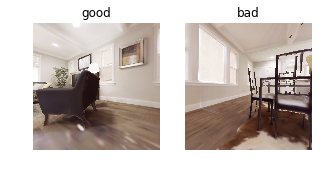

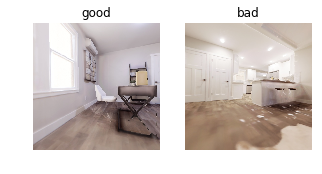

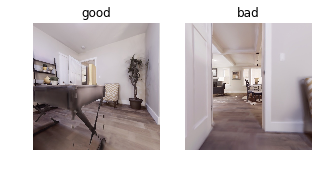

trajectory 2
345 found, 1332 bad candidates
num_imgs 1677
[337, 669, 1003, 1293, 1419]


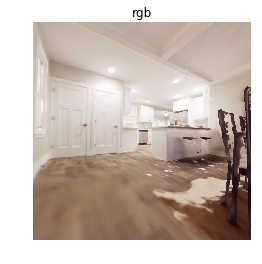

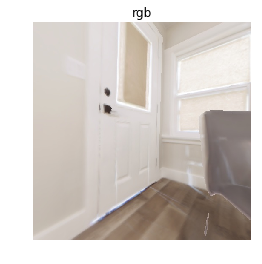

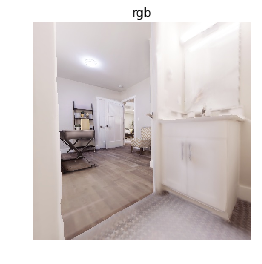

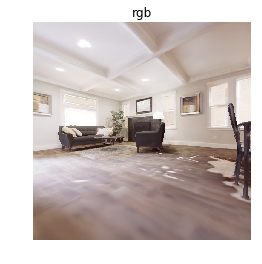

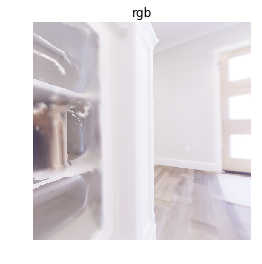

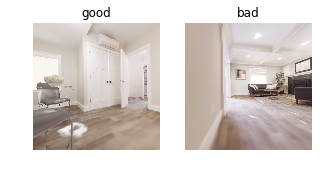

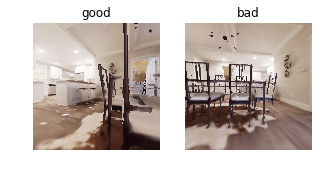

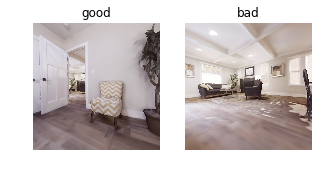

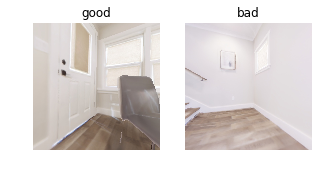

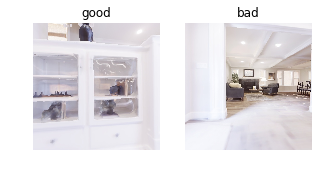

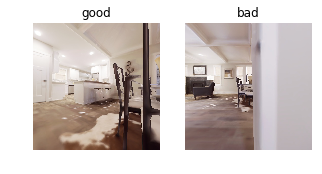

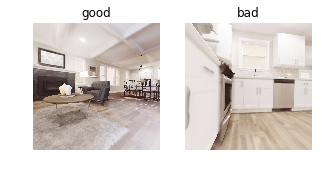

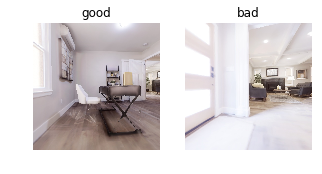

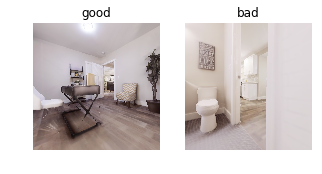

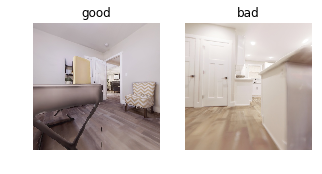

In [27]:
for traj in range(1, 3):
    print(f'trajectory {traj}')
    img_dir = os.path.join(data_dir, f'{traj}/default/rgb')
    depth_dir = os.path.join(data_dir, f'{traj}/default/depth')
    s = PickGoodCandidates(img_dir=img_dir, depth_dir=depth_dir)
    xs = s.sample_uniform_nn(5)
    print(xs)
    for x in xs:
        s.vis(x)
    s.visualize_good_bad(10)